In [2]:
import keras
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from PIL import Image
import os

from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Conv2D,MaxPooling2D,Flatten,Conv1D
from keras.preprocessing import sequence

from sklearn.model_selection import train_test_split


import json
import numpy as np
import pandas as pd
from sklearn import preprocessing
import keras
from keras.layers import Input,Dense,Lambda,Dropout
from keras.models import Model
import os
import numpy as np
from keras.preprocessing import image as image_p
from keras.applications.imagenet_utils import preprocess_input
from keras.applications.vgg16 import VGG16
import time
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
import pickle
import matplotlib.image as mpimg
from keras.preprocessing import image
from PIL import Image

/home/parmeet/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/parmeet/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [1]:
# !pip install --upgrade tensorflow-gpu==1.4.0

In [6]:
##loading the image

In [2]:
cnn_base = VGG16(input_shape=(224,224,3),include_top=True,weights='imagenet')
# We'll extract features at the final pool layer.
model = Model(
    inputs=cnn_base.input,
    outputs=cnn_base.get_layer('fc1').output
)
def extract_image(image_path,model):
        img = image.load_img(image_path, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)

        features = model.predict(x)
        return features

In [3]:
cnn_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [4]:
labels = []
image_features = []

labels_test = []
image_features_test = []

for label in os.listdir("../split_images"):
    listdir = np.array(sorted(os.listdir("../split_images/"+label),key=lambda x: int(x.split(".")[0])))
    print(label,len(listdir))
    batch_sz = 100
    features = []
    labs = []
    for file in listdir:
        features.append(np.array(extract_image("../split_images/"+label+'/'+file,model))[0])
        labs.append(label)
    print("Done processing features")
    X_train,X_test,y_train,y_test = train_test_split(features,labs,shuffle=False,test_size=0.3)
    image_features = image_features + X_train
    labels = labels + y_train
    
    labels_test = labels_test + y_test
    image_features_test = image_features_test + X_test

Aug 20th-26th 243
Done processing features
Aug 10th Decaying Ice Stopped Luis 456
Done processing features
Aug 14th Decaying 222
Done processing features
Sept 8th Swell 373
Done processing features
Aug 11th Decaying Ice 488
Done processing features
Sept 5th Helicopter 298
Done processing features
Discoloured Ice 136
Done processing features
Aug 29th-30th 708
Done processing features
Aug 16th-17th Helicopter 262
Done processing features
Aug 28th Stopped Ram Ice 596
Done processing features
Aug 15th Ice Under Pressure 253
Done processing features


In [6]:
num_labels = len(np.unique(labels))

In [7]:
image_f = np.array(image_features)
image_f_test = np.array(image_features_test)

In [8]:
num_of_train_examples = image_f.shape
print(num_of_train_examples)

(2821, 4096)


In [9]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

In [10]:
le.fit(list(labels)+list(labels_test))
le_labels = le.transform(labels)
le_labels_test = le.transform(labels_test)
one = preprocessing.OneHotEncoder()
one.fit(list(le_labels.reshape(-1,1))+list(le_labels_test.reshape(-1,1)))
one_labels = one.transform(le_labels.reshape(-1,1))
one_labels_test = one.transform(le_labels_test.reshape(-1,1))

In [11]:
image_input = Input(shape=(4096,))
output = Dense(num_labels,activation='softmax')(image_input)
model_dense = Model(image_input, output)
model_dense.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['acc'])
model_dense.save_weights('vgg-simple-model.h5')

In [12]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=10,shuffle=True)
validation_cvscores = []
test_cvscores = []
epochs = 1
for train, test in kf.split(image_f):
    model_dense.load_weights('vgg-simple-model.h5')
    hist = model_dense.fit(image_f[train], one_labels[train], epochs=5, verbose=1)
    print(hist.history)
    val_score = model_dense.evaluate(image_f[test], one_labels[test], verbose=0)
    test_score = model_dense.evaluate(image_f_test, one_labels_test, verbose=0)
    validation_cvscores.append(val_score)
    test_cvscores.append(test_score)

Epoch 1/5
2538/2538 [==============================] - 0s 84us/step - loss: 0.7381 - acc: 0.9169
Epoch 2/5
2538/2538 [==============================] - 0s 67us/step - loss: 0.0083 - acc: 0.9972
Epoch 3/5
2538/2538 [==============================] - 0s 68us/step - loss: 8.5654e-06 - acc: 1.0000
Epoch 4/5
2538/2538 [==============================] - 0s 66us/step - loss: 4.4307e-05 - acc: 1.0000
Epoch 5/5
2538/2538 [==============================] - 0s 66us/step - loss: 5.2427e-07 - acc: 1.0000
{'loss': [0.738127902185003, 0.008328125056318888, 8.565447510566996e-06, 4.4307086326754015e-05, 5.242651357081918e-07], 'acc': [0.9168636721828212, 0.9972419227738377, 1.0, 1.0, 1.0]}
Epoch 1/5
2539/2539 [==============================] - 0s 66us/step - loss: 0.9259 - acc: 0.9074
Epoch 2/5
2539/2539 [==============================] - 0s 67us/step - loss: 0.0046 - acc: 0.9992
Epoch 3/5
2539/2539 [==============================] - 0s 66us/step - loss: 0.0146 - acc: 0.9965
Epoch 4/5
2539/2539 [=====

In [13]:
test_cvscores

[[3.6910053534815845, 0.6606260296540363],
 [3.9668154536053346, 0.5922570016474464],
 [5.282018373445511, 0.5510708401976936],
 [3.356771789816114, 0.6367380560131796],
 [3.6328327045938633, 0.6705107084019769],
 [3.836922322102349, 0.627677100494234],
 [4.808565491202465, 0.5749588138385503],
 [3.921431562301082, 0.6367380560131796],
 [3.8416534108232216, 0.6350906095551895],
 [4.224790285706659, 0.6408566721581549]]

In [14]:
np.array(test_cvscores)[:,1]*100

array([66.06260297, 59.22570016, 55.10708402, 63.6738056 , 67.05107084,
       62.76771005, 57.49588138, 63.6738056 , 63.50906096, 64.08566722])

In [15]:
print(np.mean(np.array(validation_cvscores)[:,1]))
print(np.std(np.array(validation_cvscores)[:,1]))
print(np.mean(np.array(test_cvscores)[:,1]))
print(np.std(np.array(test_cvscores)[:,1]))

0.9797872341482353
0.043720686072083986
0.6226523887973642
0.03600424411833634


In [16]:
print("Validation Standard Deviation",np.std(validation_cvscores))
print("Test Standard Deviation",np.std(test_cvscores))

Validation Standard Deviation 0.5968075890244059
Test Standard Deviation 1.7604141289352693


In [17]:
plt.plot(np.arange(epochs*num_of_batches),loss_values)
plt.title("Learning Curve")
plt.xlabel('Subsequent Batches')
plt.ylabel('Categorial Cross Entropy')

NameError: name 'num_of_batches' is not defined

NameError: name 'images_to_show' is not defined

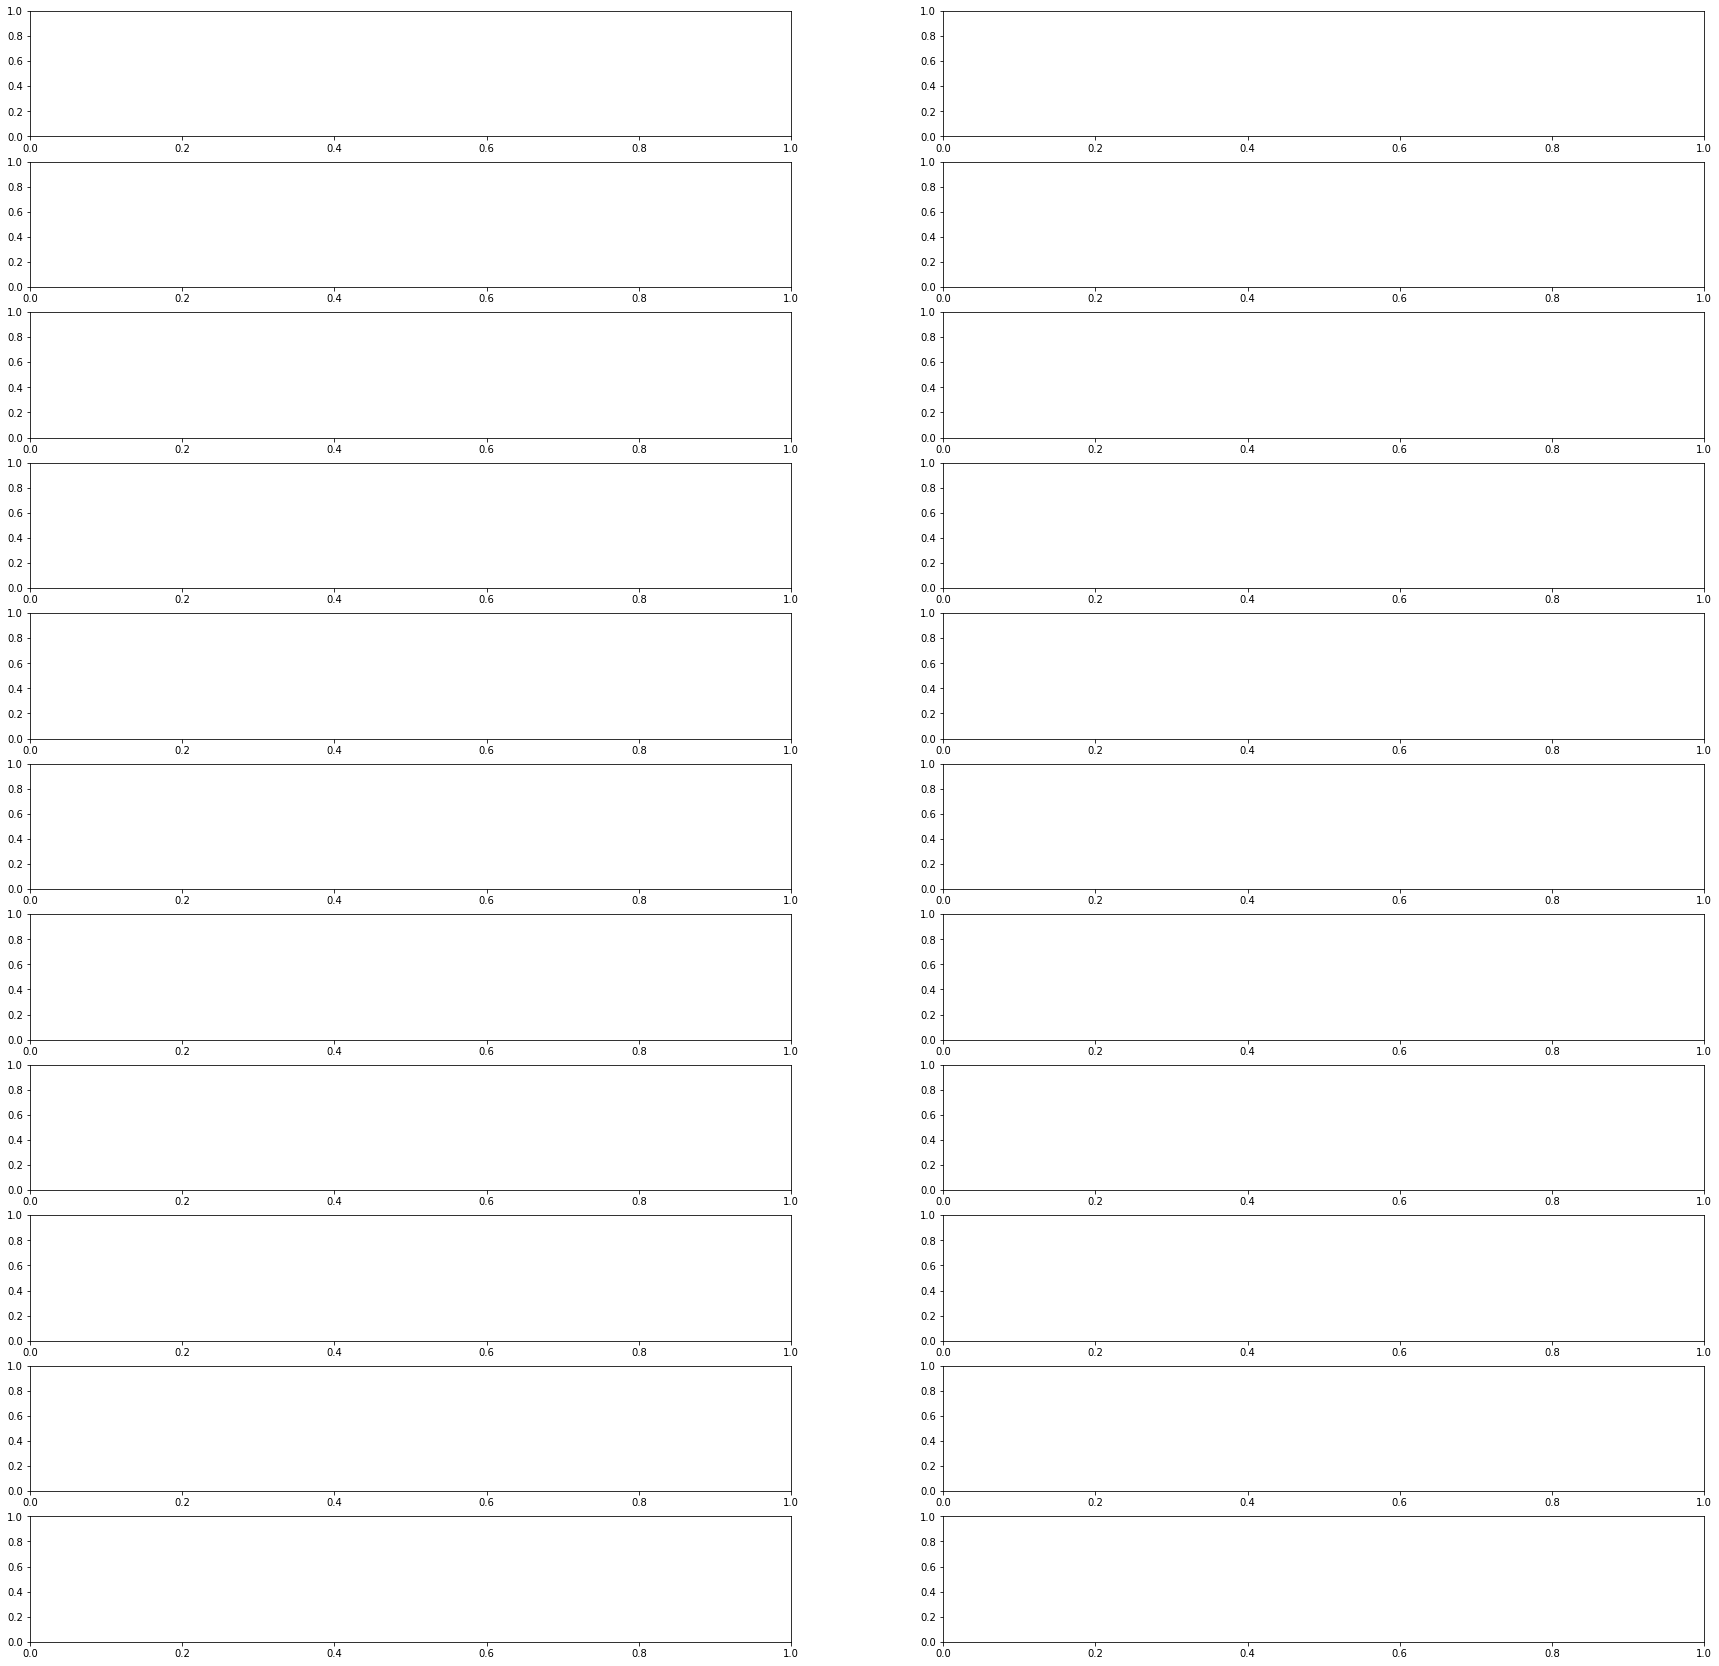

In [18]:
f, axarr = plt.subplots(num_labels,2)
f.set_figheight(30)
f.set_figwidth(30)
for i in range(num_labels):
    axarr[i,0].imshow(mpimg.imread(images_to_show[i][0]))
    axarr[i,0].title.set_text("train "+images_to_show[i][2])
    axarr[i,1].imshow(mpimg.imread(images_to_show[i][1]))
    axarr[i,1].title.set_text("test "+images_to_show[i][2])
plt.show()
plt.savefig('transferlearning.png')
# import matplotlib.pyplot as plt
# import matplotlib.image as mpimg
# image = mpimg.imread(images[0])
# plt.imshow(image)
# plt.show()